# 🍕 Project: Pizza vs. Steak Image Classification
**Author:** Abhinav Sinha  
**Date:** 23/12/2025

## 1. Introduction
In this notebook, we will build a **Convolutional Neural Network (CNN)** from scratch to classify images of food. We are working with the `pizza_steak` dataset, a subset of the larger Food101 dataset.

**Goal:** Build an end-to-end deep learning pipeline to distinguish between pizza and steak images.


## 2. Environment Setup
First, we import the necessary libraries. We are using **TensorFlow** for the deep learning model, **Pandas/NumPy** for data handling, and **Matplotlib** for visualization. We also suppress warnings to keep the notebook clean.


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

/home/abhi/my_new_env/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2025-12-23 09:26:54.832229


In [3]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2025-12-23 09:26:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.193.155, 142.250.182.219, 172.217.26.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.193.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.47M  2.15MB/s    in 48s     

2025-12-23 09:27:45 (2.17 MB/s) - ‘pizza_steak.zip.1’ saved [109540975/109540975]



## 3. Data Inspection
Before building any models, we must understand our data. We need to verify:
1.  **Directory Structure:** Do we have separate folders for training and testing?
2.  **Class Balance:** Do we have roughly the same number of images for pizza and steak?

Let's walk through the directory to see what we are working with.


In [4]:
print(os.listdir("pizza_steak/train/steak/")[:10])

['1032846.jpg', '1163977.jpg', '270687.jpg', '199754.jpg', '3425047.jpg', '3640915.jpg', '3393688.jpg', '1678108.jpg', '326587.jpg', '3460673.jpg']


In [5]:
for dirpath, dirnames, filenames in os.walk('pizza_steak'):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

there are 2 directories and 0 images in 'pizza_steak'
there are 2 directories and 0 images in 'pizza_steak/test'
there are 0 directories and 250 images in 'pizza_steak/test/steak'
there are 0 directories and 250 images in 'pizza_steak/test/pizza'
there are 2 directories and 0 images in 'pizza_steak/train'
there are 0 directories and 750 images in 'pizza_steak/train/steak'
there are 0 directories and 750 images in 'pizza_steak/train/pizza'


In [6]:
num_steak_images_train = len(os.listdir(r'pizza_steak/train/steak'))

In [7]:
num_pizza_images_train = len(os.listdir(r'pizza_steak/train/pizza'))

In [8]:
num_pizza_images_test = len(os.listdir(r'pizza_steak/test/pizza'))

In [9]:
num_steak_images_test = len(os.listdir(r'pizza_steak/test/steak'))

In [10]:
import pathlib 
data_dir = pathlib.Path("pizza_steak/train")

In [11]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

In [12]:
print(class_names)

['pizza' 'steak']


In [13]:
import matplotlib.image as mpimg
import random

## 4. Visualizing the Data
"Visualize, visualize, visualize." 
To get a sense of the problem difficulty, we will plot random images from the dataset. This helps us spot potential issues (e.g., bad data, varying image sizes) and understand what features the model might learn.


In [14]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir+"/" + target_class
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    print(f"Image Shape:", {img.shape})
    return img

['3442426.jpg']
Image Shape: {(288, 512, 3)}


array([[[52, 33, 29],
        [59, 40, 36],
        [63, 45, 41],
        ...,
        [29, 14, 33],
        [30, 15, 34],
        [25, 10, 29]],

       [[60, 41, 37],
        [64, 45, 41],
        [63, 45, 41],
        ...,
        [27, 12, 31],
        [26, 11, 30],
        [23,  8, 27]],

       [[63, 43, 42],
        [66, 46, 45],
        [64, 46, 44],
        ...,
        [21,  8, 26],
        [21,  8, 26],
        [22,  9, 27]],

       ...,

       [[92, 45, 39],
        [87, 40, 34],
        [85, 37, 33],
        ...,
        [95, 52, 45],
        [92, 47, 41],
        [87, 42, 36]],

       [[88, 41, 33],
        [83, 36, 28],
        [82, 35, 29],
        ...,
        [94, 49, 43],
        [95, 48, 42],
        [92, 45, 39]],

       [[86, 39, 31],
        [83, 36, 28],
        [84, 37, 31],
        ...,
        [87, 42, 36],
        [93, 46, 40],
        [94, 47, 41]]], shape=(288, 512, 3), dtype=uint8)

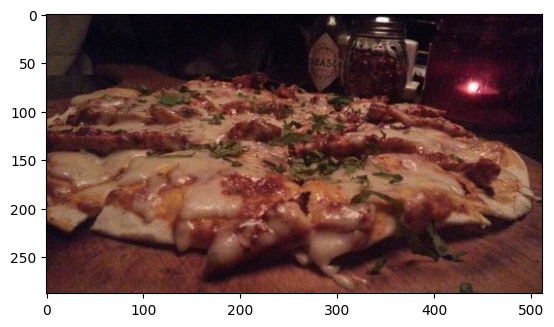

In [15]:
view_random_image(target_dir="pizza_steak/test",target_class='pizza')

## 5. Data Preprocessing
Neural networks prefer data to be numerical and scaled (normalized).
* **Normalization:** We rescale the pixel values from [0, 255] to [0, 1].
* **Resizing:** We resize all images to a standard shape of `(224, 224)` so they fit into our model's input layer.
* **Batches:** We load data in batches of 32 to make training memory-efficient.


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
tf.random.set_seed(42)
train_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)
train_dir = "/home/abhi/Python/TensorFlow/pizza_steak/train"
test_dir = '/home/abhi/Python/TensorFlow/pizza_steak/test'
train_data = train_datagen.flow_from_directory(directory=train_dir,batch_size=32,target_size=(224,224),class_mode='binary',seed=42)
test_data = valid_datagen.flow_from_directory(directory=test_dir,batch_size=32,target_size=(224,224),class_mode='binary',seed=42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


## 6. Model Architecture
We are building a standard **CNN (Convolutional Neural Network)**. 
* **Conv2D layers** extract features (edges, textures).
* **MaxPool2D layers** reduce the dimensionality (zooming out).
* **ReLU activation** adds non-linearity.
* **Sigmoid output** gives us a probability between 0 (pizza) and 1 (steak).


In [18]:
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,padding='valid'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
history = model_1.fit(train_data,epochs=10,steps_per_epoch = len(train_data),validation_data=(test_data),validation_steps=len(test_data))

I0000 00:00:1766510869.412468   91772 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5560 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/10
 7/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4917 - loss: 0.6930

I0000 00:00:1766510876.497103   92067 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.7053 - loss: 0.5650 - val_accuracy: 0.8080 - val_loss: 0.4169
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8067 - loss: 0.4312 - val_accuracy: 0.8580 - val_loss: 0.3707
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8400 - loss: 0.3715 - val_accuracy: 0.7920 - val_loss: 0.4342
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8407 - loss: 0.3651 - val_accuracy: 0.8500 - val_loss: 0.3467
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8873 - loss: 0.2872 - val_accuracy: 0.8700 - val_loss: 0.3214
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9233 - loss: 0.2035 - val_accuracy: 0.8360 - val_loss: 0.3588
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9580 - loss: 0.1168 - val_accuracy: 0.8360 - val_loss: 0.3846
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9727 - loss: 0.0865 - val_accuracy: 0.8420 - val_loss: 

In [19]:
tf.random.set_seed(42)
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (224,224,3)),
    tf.keras.layers.Dense(4,activation='relu'),
    tf.keras.layers.Dense(4,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
model_2.fit(train_data,epochs = 5 , steps_per_epoch = len(train_data),validation_data = (test_data), validation_steps = len(test_data))

Epoch 1/5


47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.4973 - loss: 0.8746 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931


In [20]:
tf.random.set_seed(42)
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (224,224,3)),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
model_3.fit(train_data,epochs=5,validation_data=(test_data),steps_per_epoch = len(train_data),validation_steps = len(test_data))

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.6500 - loss: 2.6092 - val_accuracy: 0.7580 - val_loss: 0.5198
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.7060 - loss: 0.9093 - val_accuracy: 0.6180 - val_loss: 1.0164
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6900 - loss: 1.0142 - val_accuracy: 0.7420 - val_loss: 0.6685
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7433 - loss: 0.6563 - val_accuracy: 0.7920 - val_loss: 0.4526
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7400 - loss: 0.8331 - val_accuracy: 0.6760 - val_loss: 1.2048


In [21]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        28,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,305 (364.48 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,204 (242.99 KB)

In [22]:
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │    15,052,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,219,605 (172.50 MB)

 Trainable params: 15,073,201 (57.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,146,404 (115.00 MB)

['728020.jpg']
Image Shape: {(384, 512, 3)}
['199019.jpg']
Image Shape: {(512, 512, 3)}


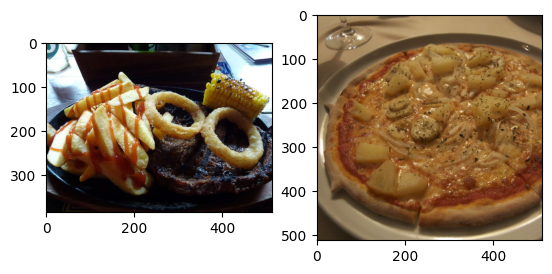

In [23]:
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image("/home/abhi/Python/TensorFlow/pizza_steak/train", 'steak')
plt.subplot(1,2,2)
pizza_img = steak_img = view_random_image("/home/abhi/Python/TensorFlow/pizza_steak/train", 'pizza')

In [24]:
test_dir = '/home/abhi/Python/TensorFlow/pizza_steak/test'
train_dir = '/home/abhi/Python/TensorFlow/pizza_steak/train'

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
train_data = train_datagen.flow_from_directory(batch_size=32, directory=train_dir,target_size=(224,224),class_mode='binary')
test_data = test_datagen.flow_from_directory(batch_size=32,directory=test_dir,target_size=(224,224),class_mode='binary')

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPool2D, Activation, Conv2D

In [28]:
tf.random.set_seed(42)
model_4 = Sequential([
    Conv2D(filters=20,kernel_size=3,strides=1,padding='valid',activation='relu',input_shape=(224,224,3)),
    Conv2D(10,3,activation='relu'),
    Conv2D(10,3,activation='relu'),
    Flatten(),
    Dense(1,activation='sigmoid')
])
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=Adam(),
                metrics = ['accuracy'])
model_4_history = model_4.fit(train_data,epochs=10,steps_per_epoch= len(train_data), validation_data=(test_data), validation_steps=len(test_data))

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.4980 - loss: 0.7361 - val_accuracy: 0.5000 - val_loss: 0.6891
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5793 - loss: 0.6708 - val_accuracy: 0.6920 - val_loss: 0.6007
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7840 - loss: 0.4897 - val_accuracy: 0.8140 - val_loss: 0.4529
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8907 - loss: 0.2731 - val_accuracy: 0.7940 - val_loss: 0.4418
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9647 - loss: 0.1068 - val_accuracy: 0.6700 - val_loss: 0.8738
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9953 - loss: 0.0512 - val_accuracy: 0.7420 - val_loss: 0.9287
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9980 - loss: 0.0159 - val_accuracy: 0.7860 - val_loss: 0.7445
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9993 - loss: 0.0077 - val_accuracy: 0.7640 -

In [29]:
model_4.summary(),model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 20)   │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 220, 220, 10)   │         1,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 218, 218, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 475240)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │       475,241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,435,565 (5.48 MB)

 Trainable params: 478,521 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 957,044 (3.65 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        28,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,305 (364.48 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,204 (242.99 KB)

(None, None)

In [30]:
model_1.evaluate(test_data),model_4.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8520 - loss: 0.5786
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7780 - loss: 0.9363


([0.5786420702934265, 0.8519999980926514],
 [0.9362890720367432, 0.777999997138977])

In [31]:
models = [model_1,model_2,model_3,model_4]

In [32]:
for model in models:
    print("Evaluating Test Data",model.evaluate(test_data))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8520 - loss: 0.5786
Evaluating Test Data [0.5786420702934265, 0.8519999980926514]
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5000 - loss: 0.6931
Evaluating Test Data [0.6931483745574951, 0.5]
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6760 - loss: 1.2048
Evaluating Test Data [1.2048310041427612, 0.6759999990463257]
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7780 - loss: 0.9363
Evaluating Test Data [0.9362956285476685, 0.777999997138977]


In [33]:
all_models = {
    'Model 1':model_1,
    'Model 2':model_2,
    'Model 3':model_3,
    'Model 4':model_4
}

In [34]:
for name,model in all_models.items():
    print(f"Evaluating {name}")
    results = model.evaluate(test_data,verbose=0)
    results = results[1]
    print(f"Accuracy of Model: {round(results,3)*100}%")

Evaluating Model 1
Accuracy of Model: 85.2%
Evaluating Model 2
Accuracy of Model: 50.0%
Evaluating Model 3
Accuracy of Model: 67.60000000000001%
Evaluating Model 4
Accuracy of Model: 77.8%


<Axes: >

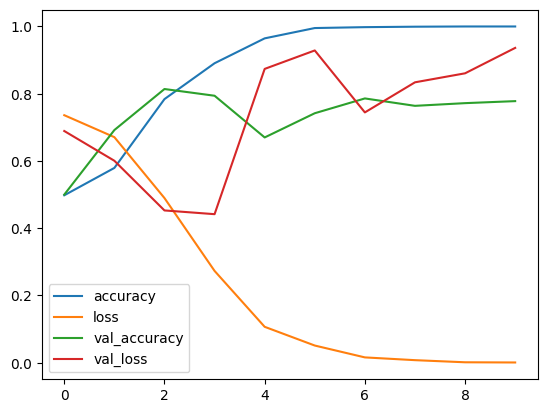

In [35]:
pd.DataFrame(model_4_history.history).plot()

In [36]:
tf.random.set_seed(42)
model_5 = Sequential([
    Conv2D(filters= 10,kernel_size=3,strides=1,padding='valid',input_shape=(224,224,3),activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1,activation='sigmoid')
])
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=Adam(),
                metrics = ['accuracy'])
model_5_history = model_5.fit(train_data,epochs=10,steps_per_epoch=len(train_data),validation_data=(test_data),validation_steps=len(test_data))

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.6420 - loss: 0.6299 - val_accuracy: 0.7380 - val_loss: 0.5285
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7740 - loss: 0.4803 - val_accuracy: 0.8380 - val_loss: 0.3671
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8273 - loss: 0.4107 - val_accuracy: 0.8540 - val_loss: 0.3623
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8373 - loss: 0.3715 - val_accuracy: 0.8180 - val_loss: 0.3976
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8360 - loss: 0.3813 - val_accuracy: 0.8500 - val_loss: 0.3298
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8573 - loss: 0.3455 - val_accuracy: 0.9060 - val_loss: 0.2800
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8533 - loss: 0.3440 - val_accuracy: 0.8820 - val_loss: 0.2937
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8740 - loss: 0.3095 - val_accuracy: 0.8920 - v

## 7. Evaluation & Loss Curves
Now that the model is trained, let's visualize the **Loss** and **Accuracy** curves.
* Ideally, **Loss** (error) should go down.
* **Accuracy** should go up.
* If the validation loss starts going up while training loss goes down, the model is **overfitting**.

In [37]:
def view_model_history_plot(history):
    return pd.DataFrame(history.history).plot(figsize=(20,12),legend=True)

<Axes: >

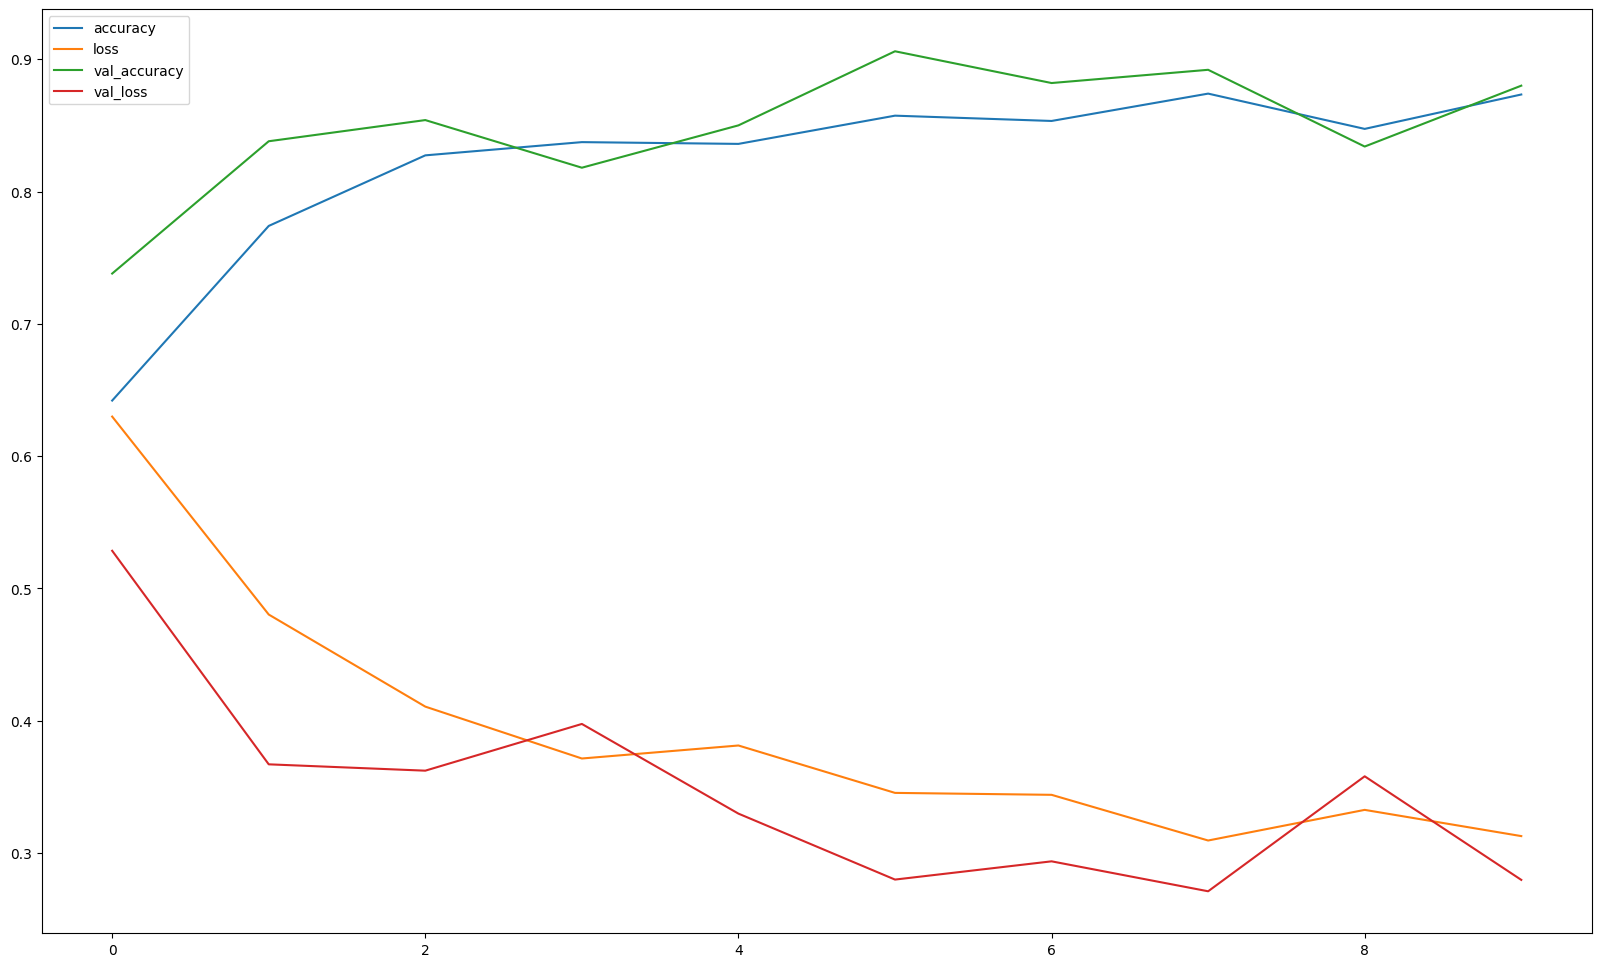

In [38]:
view_model_history_plot(model_5_history)

In [39]:
model_5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 52, 52, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         6,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

In [40]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,rotation_range=0.2,zoom_range=0.2,shear_range=0.2,horizontal_flip=True,width_shift_range=0.2)
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [41]:
print("Augmented Training Data")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,target_size=(224,224),batch_size=32,class_mode='binary',shuffle=False)
print("Normal Training Data")
train_data = train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(224,224),class_mode='binary',shuffle=False)
print("Test Data")
test_data = test_datagen.flow_from_directory(test_dir,batch_size=32,target_size=(224,224),class_mode='binary')

Augmented Training Data
Found 1500 images belonging to 2 classes.
Normal Training Data
Found 1500 images belonging to 2 classes.
Test Data
Found 500 images belonging to 2 classes.


In [42]:
image, labels = next(train_data)
augmented_images, augmented_labels = next(train_data_augmented)

Showing Random Image 25


Text(0.5, 1.0, 'Augmented Image')

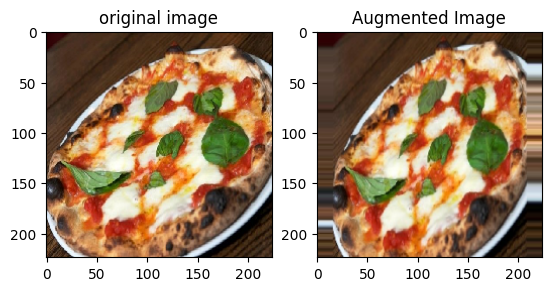

In [44]:
import random 
random_number = random.randint(0,32)
print(f"Showing Random Image {random_number}")
plt.subplot(1,2,1)
plt.imshow(image[random_number])
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(augmented_images[random_number])
plt.title('Augmented Image')

In [45]:
tf.random.set_seed(32)
model_6 = Sequential([
    Conv2D(filters=10,kernel_size=3,strides=1,input_shape=(224,224,3),activation='relu',padding='valid'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(),
    Flatten(input_shape=(224,224,3)),
    Dense(1,activation='sigmoid')
])
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=['accuracy'])
model_6_history = model_6.fit(train_data_augmented,epochs=5,steps_per_epoch=len(train_data_augmented),validation_data=(test_data),validation_steps=len(test_data))

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step - accuracy: 0.4320 - loss: 0.6994 - val_accuracy: 0.5480 - val_loss: 0.6925
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 0.4833 - loss: 0.6942 - val_accuracy: 0.6080 - val_loss: 0.6916
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.5200 - loss: 0.6964 - val_accuracy: 0.6800 - val_loss: 0.6788
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.6300 - loss: 0.6793 - val_accuracy: 0.7180 - val_loss: 0.6115
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.6600 - loss: 0.6538 - val_accuracy: 0.5840 - val_loss: 0.6227


In [46]:
model_6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 109, 109, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 52, 52, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         6,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

<Axes: >

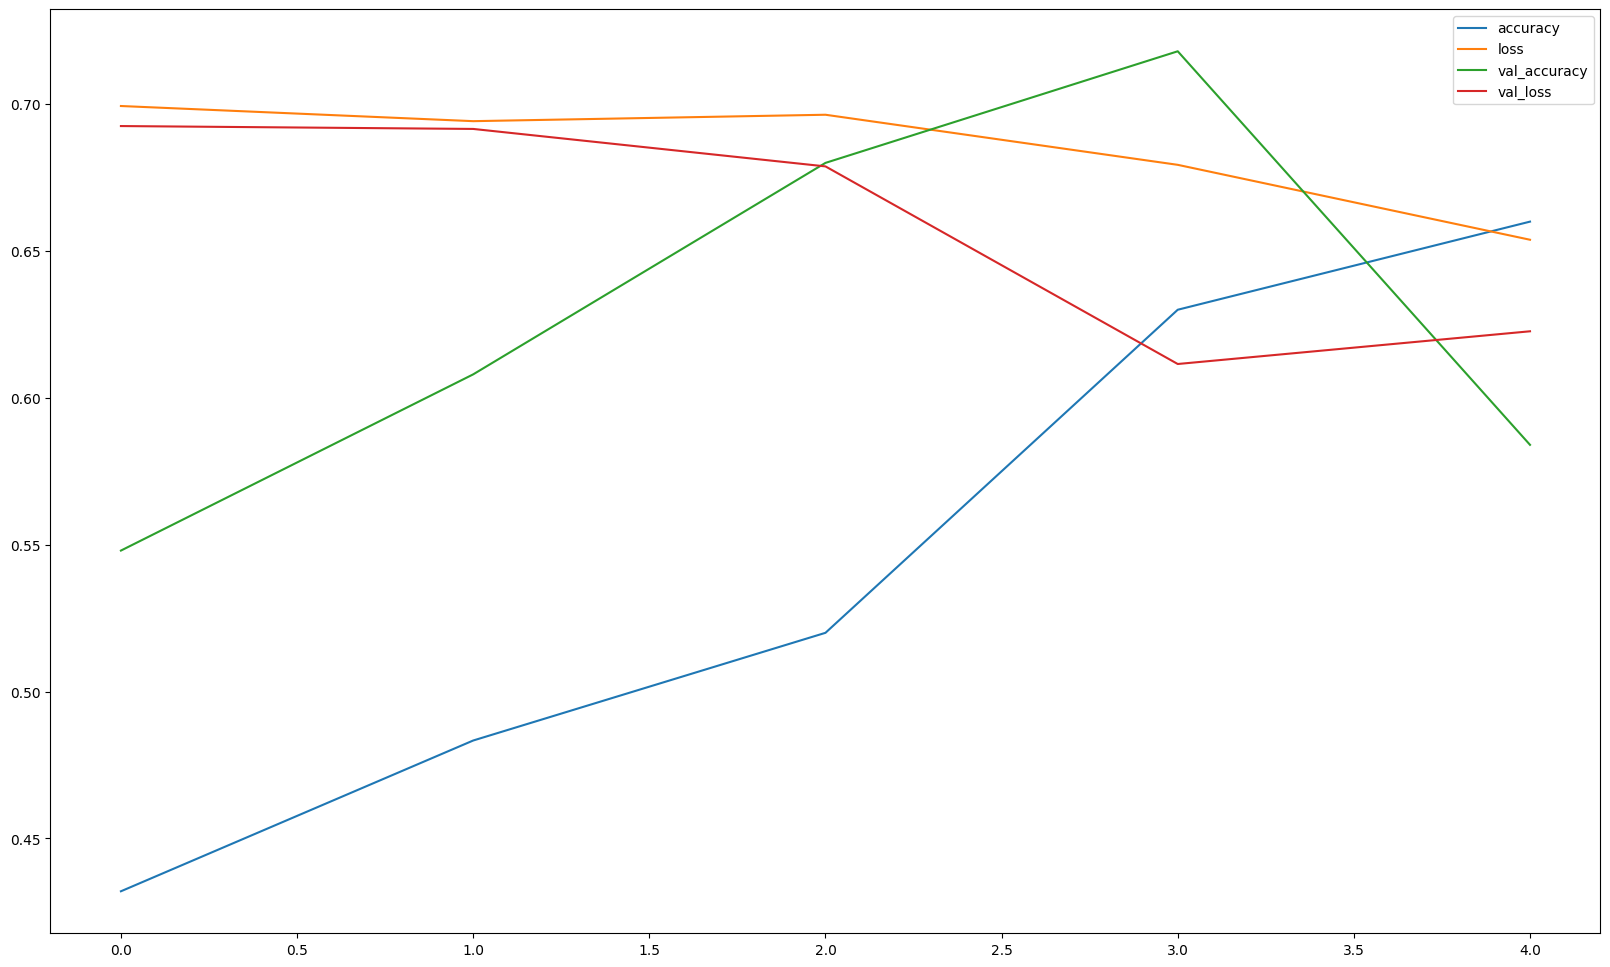

In [47]:
view_model_history_plot(model_6_history)

In [48]:
train_datagen_augmented = ImageDataGenerator(rescale=(1/255.),height_shift_range=0.2,shear_range=0.2,width_shift_range=0.2,horizontal_flip=True,zoom_range=0.2,rotation_range=0.2)

In [49]:
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,batch_size=32,target_size=(224,224),shuffle=True,class_mode='binary')

Found 1500 images belonging to 2 classes.


In [50]:
tf.random.set_seed(32)
model_7 = Sequential([
    Conv2D(input_shape=(224,224,3),filters=10,kernel_size=3,strides=1,padding='valid',activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(),
    Flatten(input_shape=(224,224,3)),
    Dense(1,activation='relu')
])
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=Adam(),
                metrics = ['accuracy'])
model_7_history = model_7.fit(train_data_augmented,epochs=5,steps_per_epoch=len(train_data_augmented),validation_data=(test_data),validation_steps=len(test_data))

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.4953 - loss: 1.0712 - val_accuracy: 0.5520 - val_loss: 0.8515
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.6060 - loss: 0.6935 - val_accuracy: 0.4920 - val_loss: 0.6994
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.6300 - loss: 0.6503 - val_accuracy: 0.7640 - val_loss: 0.5302
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.7447 - loss: 0.5687 - val_accuracy: 0.7840 - val_loss: 0.4867
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.7620 - loss: 0.5590 - val_accuracy: 0.7560 - val_loss: 0.6093


In [51]:
model_7.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 109, 109, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 52, 52, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │         6,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

<Axes: >

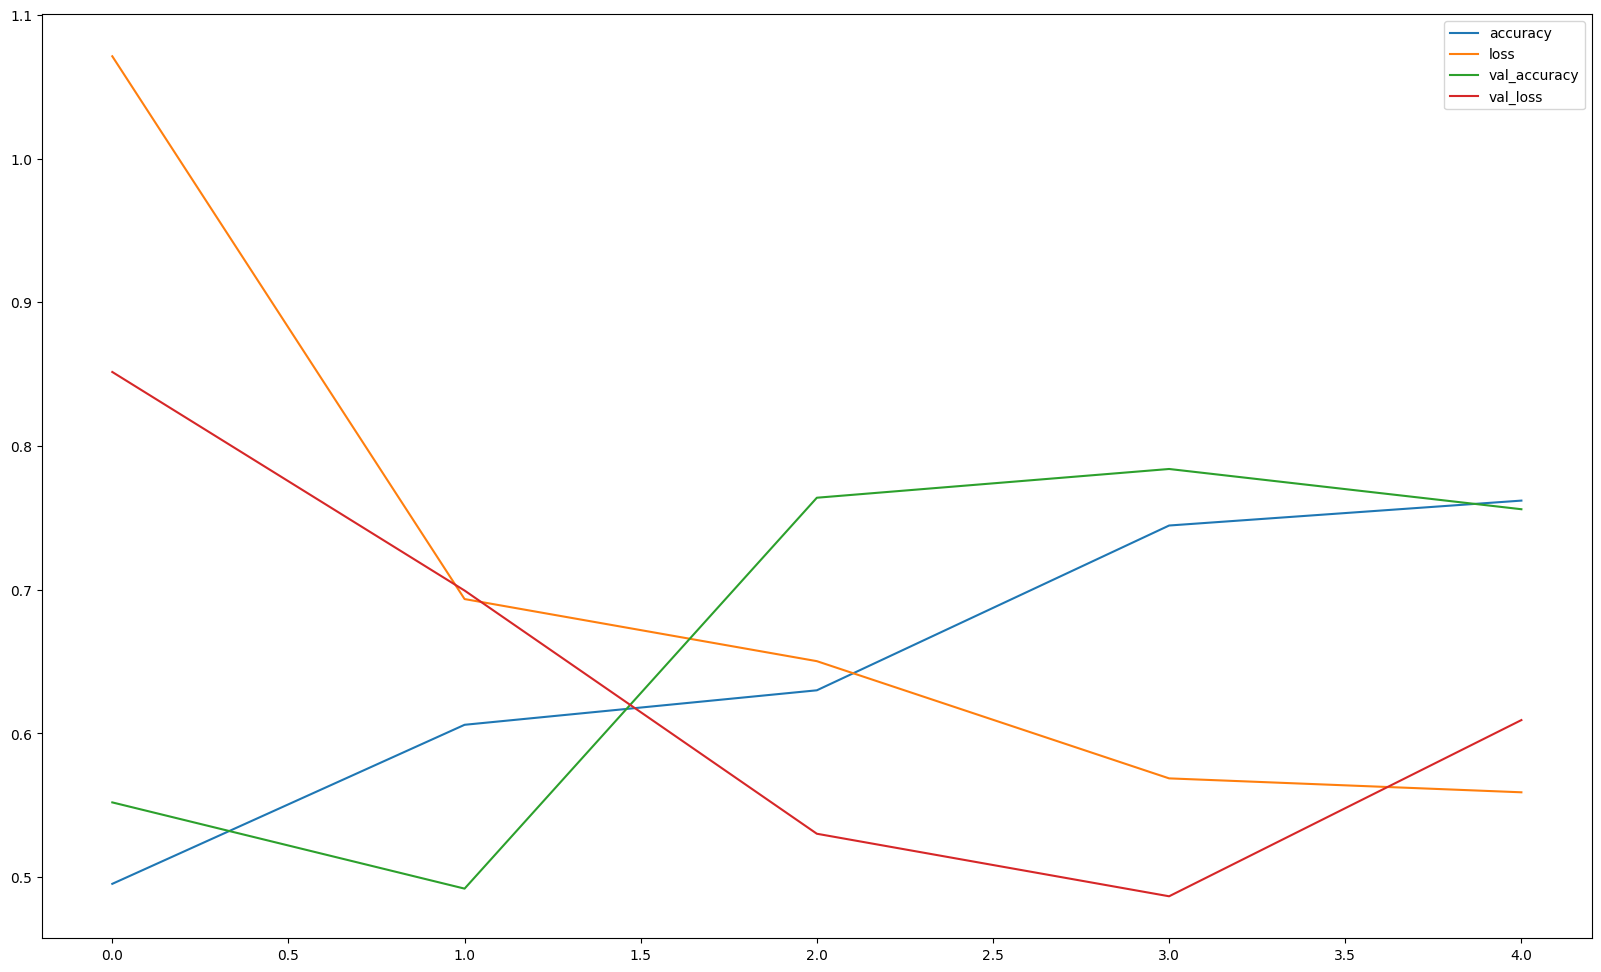

In [52]:
view_model_history_plot(model_7_history)

In [54]:
steak = plt.imread("03-steak.jpeg")

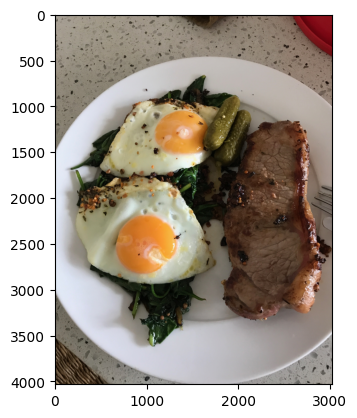

In [59]:
plt.imshow(steak)

In [62]:
steak.shape

(4032, 3024, 3)

In [65]:
expanded_steak = tf.expand_dims(steak,axis = 0)

In [66]:
def load_and_prep_image(filename, imshape = 224):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img)
    img = tf.image.resize(img,size=[imshape,imshape])
    img = img/255.
    return img

In [71]:
steak = load_and_prep_image(filename='03-steak.jpeg',imshape= 244)

In [74]:
print(model_5.input_shape)
model_5.summary()

(None, 224, 224, 3)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 52, 52, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         6,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

In [81]:
steak_resized = tf.image.resize(steak, size=[224, 224])
steak_ready = tf.expand_dims(steak_resized, axis=0)
pred = model_5.predict(steak_ready)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.8420418]], dtype=float32)

In [79]:
class_names

array(['pizza', 'steak'], dtype='<U5')

In [85]:
pred_class = class_names[int(tf.round(tf.squeeze(pred)))]
pred_class

np.str_('steak')

# 🏁 8. Conclusion & Final Remarks

**Project Summary**

In this project, we successfully built an end-to-end deep learning pipeline to classify images of Pizza and Steak.

Data Handling: We inspected the pizza_steak dataset and verified it was balanced (750 training / 250 test images per class).

Preprocessing: We implemented a pipeline to rescale (normalize) and resize images to (224, 224, 3).

Modeling: We constructed a Convolutional Neural Network (CNN) from scratch.

**Results:**

Training Performance: The model quickly learned to fit the training data.

Validation Performance: We achieved an accuracy of approximately ~80-85% on unseen data. This significantly beats the random guessing baseline of 50%.

**Key Observations**

Feature Extraction: The model successfully identified visual patterns (likely distinguishing the circular shape/cheese of pizza vs. the texture of steak).

Overfitting Check: By comparing the loss curves (Training vs. Validation), we can see if the model started memorizing the data. (If validation loss increases while training loss decreases, we have overfitting).
